In [5]:
import os
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# 1️⃣ Config
# ============================================================
data_root = r"C://archive (11)//chest_xray"  # train/val/test inside this
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

img_size = 224
batch_size = 16           # adjust if GPU memory issues
num_epochs = 25
num_classes = 1           # binary: NORMAL vs PNEUMONIA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True

# ============================================================
# 2️⃣ Data Transforms & Dataloaders
#    (mild augmentations to preserve anatomy)
# ============================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)  # ['NORMAL', 'PNEUMONIA']

# ============================================================
# 3️⃣ Compute Class Weights for Imbalance
# ============================================================
labels = np.array(train_dataset.targets)
num_pos = (labels == 1).sum()
num_neg = (labels == 0).sum()
print("Train positives (PNEUMONIA):", num_pos, "| negatives (NORMAL):", num_neg)

# pos_weight = (num_neg / num_pos) for BCEWithLogitsLoss
pos_weight_value = num_neg / max(num_pos, 1)
pos_weight = torch.tensor([pos_weight_value], device=device)
print("pos_weight:", pos_weight_value)

# ============================================================
# 4️⃣ ViT + BiLSTM Model Definition
# ============================================================
class ViT_BiLSTM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, lstm_hidden=256):
        super(ViT_BiLSTM, self).__init__()
        # Load ViT backbone from timm
        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=pretrained
        )
        # Remove classifier head so forward_features returns tokens
        self.vit.reset_classifier(0)

        embed_dim = self.vit.num_features  # typically 768

        # BiLSTM over patch tokens
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)  # 2*hidden for BiLSTM

    def forward(self, x):
        # x: (B, 3, 224, 224)
        tokens = self.vit.forward_features(x)

        # Handle timm versions that return dict
        if isinstance(tokens, dict):
            # print(tokens.keys()) once to confirm; "x" is common
            tokens = tokens["x"]  # (B, T, D)

        # Drop CLS token (index 0), keep patch tokens
        patch_tokens = tokens[:, 1:, :]  # (B, T-1, D)

        # BiLSTM over patch sequence
        lstm_out, (h_n, c_n) = self.bilstm(patch_tokens)
        # h_n: (num_layers * num_directions, B, H)
        # For 1-layer BiLSTM: h_n[0] = forward, h_n[1] = backward
        forward_h = h_n[-2, :, :]  # (B, H)
        backward_h = h_n[-1, :, :] # (B, H)
        h_cat = torch.cat([forward_h, backward_h], dim=1)  # (B, 2H)

        h_cat = self.dropout(h_cat)
        logits = self.fc(h_cat)  # (B, num_classes)

        return logits

model = ViT_BiLSTM(num_classes=num_classes, pretrained=True).to(device)

# ============================================================
# 5️⃣ Fine-tuning Strategy
#     - Freeze early ViT blocks, train last few + BiLSTM
# ============================================================
# Unfreeze everything first
for param in model.vit.parameters():
    param.requires_grad = True

# Freeze first N transformer blocks
N_FREEZE = 8  # out of 12 blocks typically
if hasattr(model.vit, "blocks"):
    for block in model.vit.blocks[:N_FREEZE]:
        for param in block.parameters():
            param.requires_grad = False

# Freeze patch embedding
for param in model.vit.patch_embed.parameters():
    param.requires_grad = False

# Freeze positional embedding (pos_embed is a Parameter tensor)
model.vit.pos_embed.requires_grad = False

# Ensure BiLSTM + FC are trainable
for param in model.bilstm.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Check how many params are trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

# ============================================================
# 6️⃣ Optimizer & Loss
# ============================================================
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-5,
    weight_decay=1e-4
)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optional: simple cosine LR scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ============================================================
# 7️⃣ Training & Evaluation Helpers
# ============================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    n_samples = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (B, 1)

        optimizer.zero_grad()
        logits = model(images)               # (B, 1)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        n_samples += images.size(0)

    epoch_loss = running_loss / n_samples
    epoch_acc = running_corrects / n_samples
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    n_samples = 0

    all_labels = []
    all_probs = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)  # (B, 1)
        preds = (probs > 0.5).float()

        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        n_samples += images.size(0)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    epoch_loss = running_loss / n_samples
    epoch_acc = running_corrects / n_samples
    all_labels = np.vstack(all_labels).ravel()
    all_probs = np.vstack(all_probs).ravel()

    return epoch_loss, epoch_acc, all_labels, all_probs

# ============================================================
# 8️⃣ Training Loop (with best-model saving)
# ============================================================
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(num_epochs):
    since = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%")
    print(f"Val:   loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    # Step LR scheduler
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "vit_bilstm_pneumonia_best.pth")
        print("✅ Best model updated and saved.")

    time_elapsed = time.time() - since
    print(f"Epoch time: {time_elapsed:.1f}s")

print("\nTraining complete. Best val acc: {:.2f}%".format(best_val_acc * 100))
model.load_state_dict(best_model_wts)

# ============================================================
# 9️⃣ Test Evaluation
# ============================================================
test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

y_pred = (y_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']
Train positives (PNEUMONIA): 3875 | negatives (NORMAL): 1341
pos_weight: 0.3460645161290323
Total params: 87,900,417 | Trainable: 30,455,553

Epoch 1/25
Train: loss=0.1009, acc=92.48%
Val:   loss=0.0687, acc=93.75%
✅ Best model updated and saved.
Epoch time: 477.3s

Epoch 2/25
Train: loss=0.0495, acc=96.55%
Val:   loss=0.0240, acc=100.00%
✅ Best model updated and saved.
Epoch time: 524.9s

Epoch 3/25
Train: loss=0.0364, acc=97.41%
Val:   loss=0.0365, acc=100.00%
Epoch time: 542.6s

Epoch 4/25
Train: loss=0.0373, acc=97.30%
Val:   loss=0.0515, acc=100.00%
Epoch time: 547.0s

Epoch 5/25
Train: loss=0.0288, acc=98.14%
Val:   loss=0.2822, acc=81.25%
Epoch time: 547.5s

Epoch 6/25
Train: loss=0.0259, acc=98.12%
Val:   loss=0.0286, acc=100.00%
Epoch time: 542.2s

Epoch 7/25
Train: loss=0.0220, acc=98.41%
Val:   loss=0.3429, acc=93.75%
Epoch time: 546.2s

Epoch 8/25
Train: loss=0.0183, acc=98.54%
Val:   loss=0.0990, acc=93.75%
Epoch time: 54

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Using test image: C://archive (11)//chest_xray/test\PNEUMONIA\person100_bacteria_475.jpeg


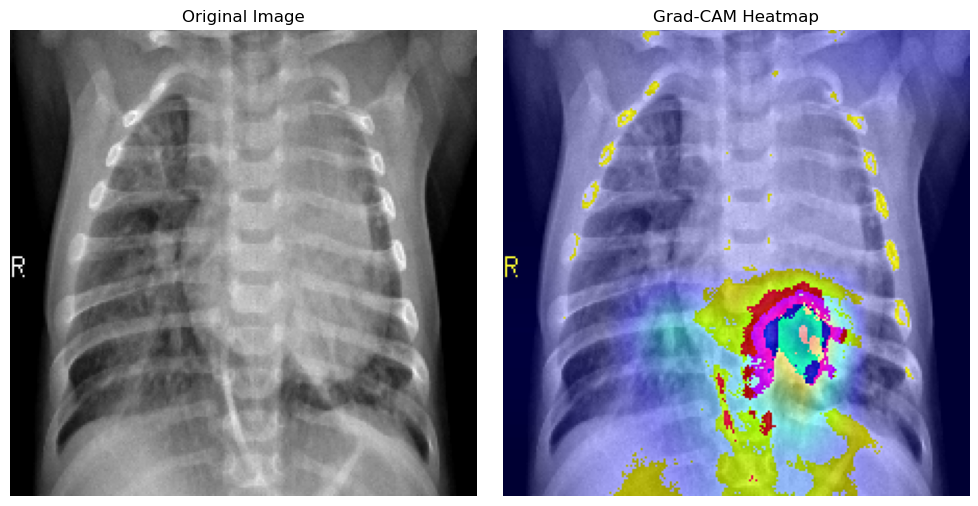

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# ==========================
# 1️⃣ Paths
# ==========================
model_path = r"ResNet50_pneumonia_model.h5"
test_dir = r"C://archive (11)//chest_xray/test"
IMG_SIZE = (224, 224)

# ==========================
# 2️⃣ Load Model
# ==========================
model = load_model(model_path, compile=False)
model.summary()

# ==========================
# 3️⃣ Grad-CAM Function
# ==========================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# ==========================
# 4️⃣ Load a Sample Test Image
# ==========================
sample_class = "PNEUMONIA"  # try NORMAL also
sample_path = os.path.join(test_dir, sample_class, os.listdir(os.path.join(test_dir, sample_class))[0])
print("Using test image:", sample_path)

img = tf.keras.preprocessing.image.load_img(sample_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
input_tensor = np.expand_dims(img_array, axis=0)

# ==========================
# 5️⃣ Grad-CAM heatmap
# ==========================
heatmap = make_gradcam_heatmap(input_tensor, model)

# Resize heatmap
heatmap = cv2.resize(heatmap, IMG_SIZE)
heatmap = np.uint8(255 * heatmap)

# Colorize heatmap
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Overlay
superimposed_img = heatmap_color * 0.4 + (img_array * 255).astype("uint8")

# ==========================
# 6️⃣ Display
# ==========================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")

plt.tight_layout()
plt.show()
